In [2]:
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
df = pd.read_excel("Superstore_Sales_Records.xls",index_col="Order Date", parse_dates=True)

df.head(2)

,Row ID,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,,,,,,,,,,
2016-11-08,1,CA-2016-152156,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
2016-11-08,2,CA-2016-152156,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [4]:
df = df[["Sales", "Profit"]]

df.sort_index()

,Sales,Profit
Order Date,,
2014-01-03,16.448,5.5512
2014-01-04,11.784,4.2717
2014-01-04,272.736,-64.7748
2014-01-04,3.540,-5.4870
2014-01-05,19.536,4.8840
...,...,...
2017-12-30,3.024,-0.6048
2017-12-30,52.776,19.7910
2017-12-30,90.930,2.7279


<Axes: xlabel='Order Date'>

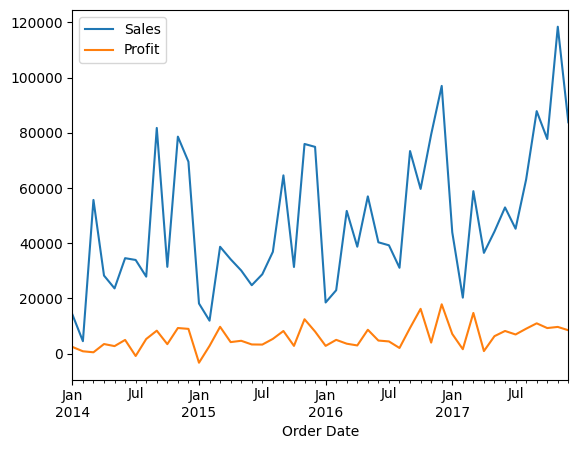

In [5]:
df = df.groupby("Order Date").sum().resample("MS").sum()
df.plot()

<Axes: xlabel='Order Date'>

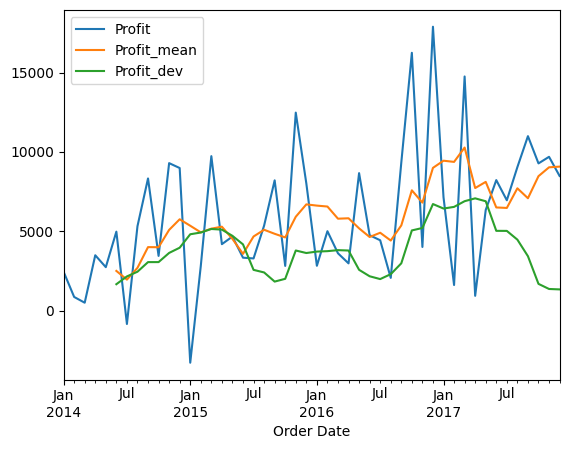

In [6]:
# Profit

df_profit = df[["Profit"]]


df_profit["Profit_mean"] = df["Profit"].rolling(6).mean()
df_profit["Profit_dev"] = df["Profit"].rolling(6).std()
df_profit[:12*10].plot() 

In [7]:
from statsmodels.tsa.stattools import adfuller
p=adfuller(df_profit["Profit"])[1]
f"P-Level: {p} <= 0.05 --> {p < 0.05}"

'P-Level: 0.054320054839669805 <= 0.05 --> False'

<Axes: xlabel='Order Date'>

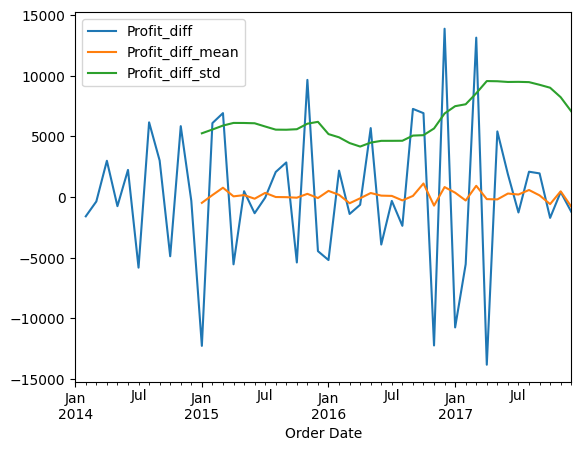

In [8]:
df_profit["Profit_diff"] = df_profit["Profit"].diff()
df_profit_diff = df_profit[["Profit_diff"]].copy()


df_profit_diff["Profit_diff_mean"] = df_profit["Profit_diff"].rolling(12).mean()
df_profit_diff["Profit_diff_std"] = df_profit["Profit_diff"].rolling(12).std()
df_profit_diff.plot()

In [9]:
p=adfuller(df_profit_diff["Profit_diff"].dropna())[1]
f"P-Level: {p} <= 0.05 --> {p < 0.05}"

'P-Level: 3.39657593009824e-20 <= 0.05 --> True'

<Axes: xlabel='Order Date'>

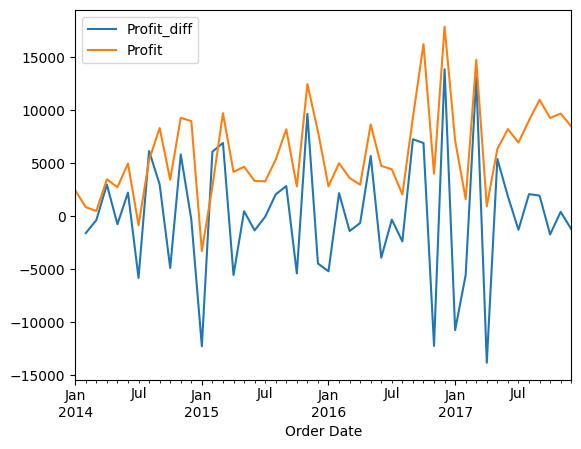

In [10]:
df_transformed = df_profit[["Profit_diff"]].copy()
df_transformed["Profit"] = df["Profit"]

df_transformed.plot()

/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: xlabel='Order Date'>

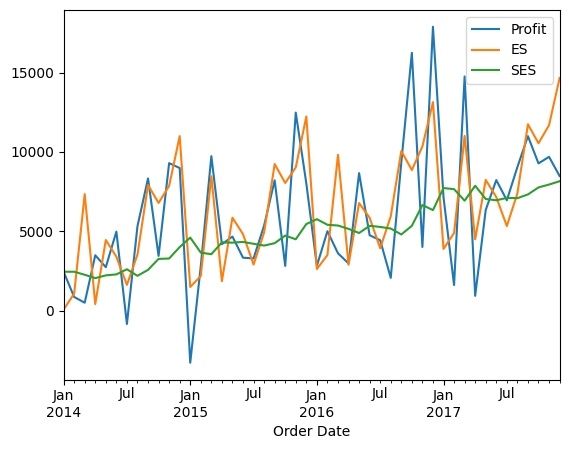

In [11]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

model = ExponentialSmoothing(df["Profit"], trend="add", seasonal="add")
df_hw = df[["Profit"]].copy()
df_hw["ES"] = model.fit().fittedvalues
df_hw["SES"] = SimpleExpSmoothing(df["Profit"]).fit().fittedvalues


df_hw.plot()

/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: xlabel='Order Date'>

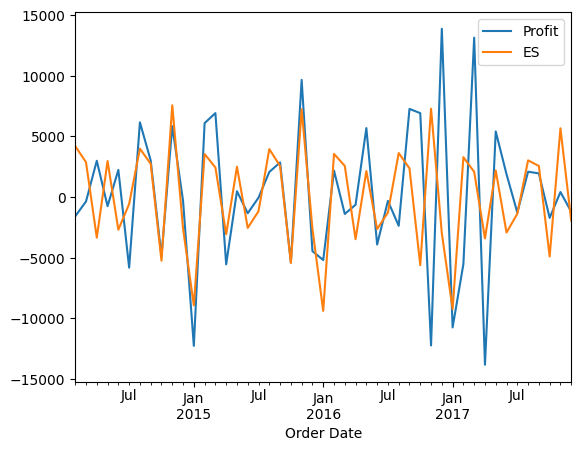

In [37]:
data = df[["Profit"]].diff().dropna()

data["ES"] = ExponentialSmoothing(data, trend="add", seasonal="add").fit().fittedvalues
data.plot()

<Axes: xlabel='Order Date'>

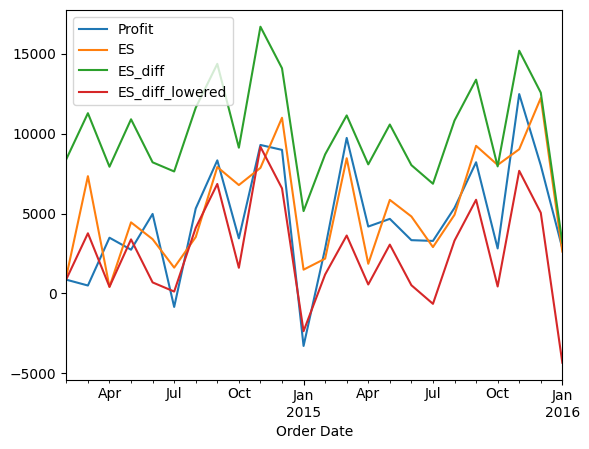

In [47]:
data_restored = data.copy()

data_restored["ES_diff"] = data["ES"].cumsum() + data["ES"].iloc[0]
data_restored["ES_diff_lowered"] = data_restored["ES_diff"] - data_restored["ES_diff"].mean()
data_restored["ES"] = df_hw["ES"].copy()
data_restored["Profit"] = df["Profit"]
data_restored[:12*2].plot()